# S&P 500 LSTM RNN

In [165]:
import tensorflow as tf
import keras 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import os

In [166]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [167]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [168]:
sp500 = yf.Ticker("^GSPC").history(period="max")
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.drop(columns=["Dividends", "Stock Splits", "Volume"])
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500 = sp500.loc["2018-01-01":].dropna()
print("Start date:", sp500.index.min())
print("End date:", sp500.index.max())
X = sp500[['Close', 'High', 'Low', 'Open']] 
y = sp500['Tomorrow']
seq_length = 100

Start date: 2018-01-02 00:00:00-05:00
End date: 2025-01-23 00:00:00-05:00


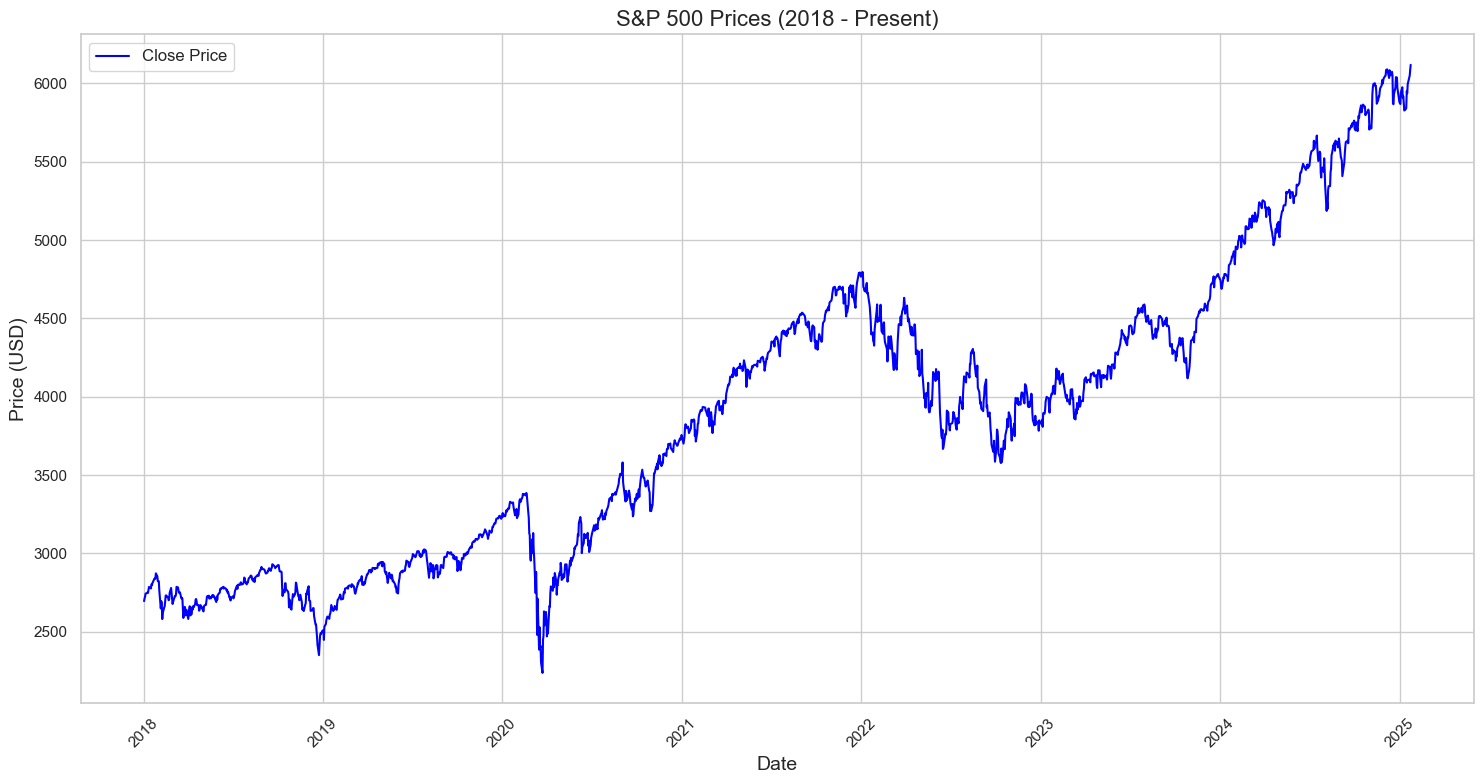

In [169]:


sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))

plt.plot(sp500.index, sp500['Close'], label='Close Price', color='blue', alpha=1)

plt.title('S&P 500 Prices (2018 - Present)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)

plt.legend(loc='upper left', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [170]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sp500.values)
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], X_seq.shape[2])

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [171]:

def prepare_datasets(X_seq, y_seq, seq_length):
    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]
    
    val_size = len(X_test) // 2
    X_val, X_test = X_test[:val_size], X_test[val_size:]
    y_val, y_test = y_test[:val_size], y_test[val_size:]
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(64)
    
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = prepare_datasets(X_seq, y_seq, seq_length)

In [172]:
def train_test(model, train_set, validate_set, learning_rate, epochs=30):
    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=10,
        restore_best_weights=True
    )
    
    optimizer =optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(
        loss=keras.losses.Huber(),
        optimizer=optimizer,
        metrics=['mae','mse']
    )
    
    history = model.fit(
        train_set,
        validation_data=validate_set,
        epochs=epochs,
        callbacks=[early_stopping_cb]
    )
    
    return history

In [173]:
rnn_model = tf.keras.Sequential([
   tf.keras.layers.Bidirectional(
       tf.keras.layers.LSTM(100, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.005)), 
       input_shape=(seq_length, 4)
   ),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Bidirectional(
       tf.keras.layers.LSTM(50, return_sequences=False)
   ),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(25),
   tf.keras.layers.Dense(1)
])

c:\Users\bigma\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [174]:
history = train_test(rnn_model, train_ds, val_ds, learning_rate=0.05, epochs=20)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.0876 - mae: 0.1183 - mse: 0.0248 - val_loss: 0.0653 - val_mae: 0.0350 - val_mse: 0.0017
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0633 - mae: 0.0491 - mse: 0.0043 - val_loss: 0.0543 - val_mae: 0.0598 - val_mse: 0.0047
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0507 - mae: 0.0389 - mse: 0.0027 - val_loss: 0.0430 - val_mae: 0.0424 - val_mse: 0.0024
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0408 - mae: 0.0354 - mse: 0.0022 - val_loss: 0.0342 - val_mae: 0.0268 - val_mse: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0330 - mae: 0.0336 - mse: 0.0021 - val_loss: 0.0282 - val_mae: 0.0425 - val_mse: 0.0023
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0266 - mae: 0.0313 - mse: 0.0018 - val_loss: 0.0224 - val_mae: 0.0306 - val_mse: 0.0012
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0216 - mae: 0.0305 - mse: 0.0017 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Mean Absolute Error: 68.73087540811566
Mean Squared Error: 7888.496345428211
Root Mean Squared Error: 88.81720748497


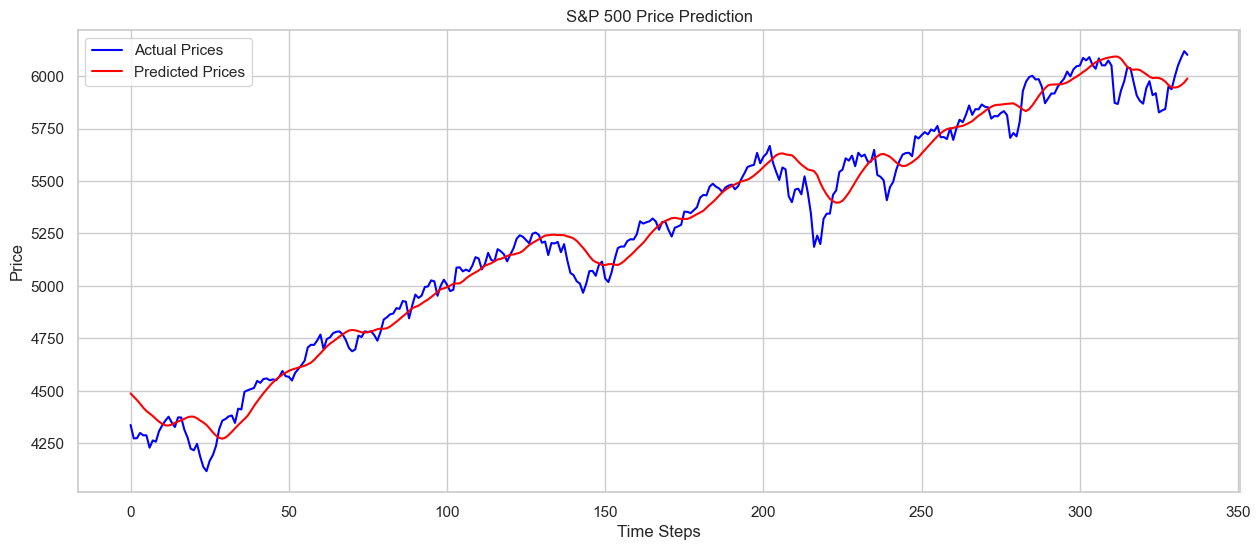

In [175]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

predictions = rnn_model.predict(test_data)

predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

plt.figure(figsize=(15,6))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(predictions_original, label='Predicted Prices', color='red')
plt.title('S&P 500 Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()